In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import LineString, Polygon, Point
# import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import json

# Get geometries of buildings and open space

In [2]:
blds=gpd.read_file('BASEMAP_Buildings/BASEMAP_Buildings.shp')
lu=gpd.read_file('CDD_LandUse/CDD_LandUse.shp')

### Ensure same CRS and metric

In [3]:
utm_zone = 19
utm_crs = f"+proj=utm +zone={utm_zone} +ellps=WGS84 +datum=WGS84 +units=m +no_defs"
lu=lu.to_crs(utm_crs)
blds=blds.to_crs(utm_crs)

In [4]:
open_space=lu.loc[lu['Category'].isin(
    ['Public Open Space', 'Privately-Owned Open Space'])].copy()

In [5]:
open_space['floors']=1

### Overlay buildings with LU

In [6]:
blds=blds.loc[blds['TYPE']=='BLDG']
blds_lu=blds.overlay(lu, 'intersection')
# blds_lu.explore(column='Category', legend=True, tiles='CartoDB Positron')

<Axes: >

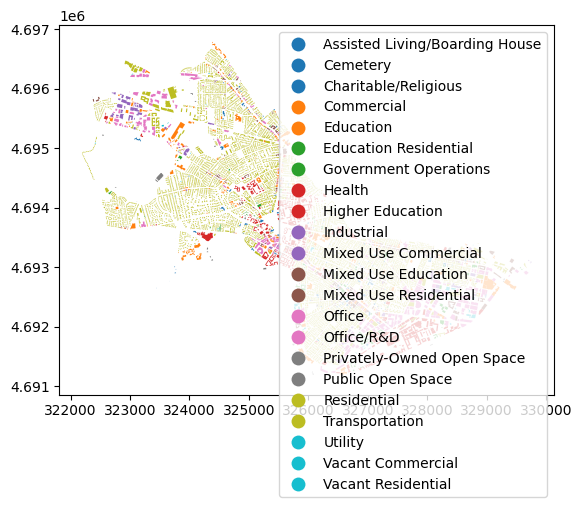

In [7]:
blds_lu.plot(column='Category', legend=True)

### Set heights

In [8]:
blds_lu['bld_height[ft]']=blds_lu['ELEV_SL']-blds_lu['BASE_ELEV']
blds_lu['floors']=(blds_lu['bld_height[ft]']/13).round()
blds_lu.loc[blds_lu['floors']<1, 'floors']=1

In [9]:
max_floors=blds_lu['floors'].max()
max_floors

21.0

Remove Open Space- using the LU polys directly for this

In [10]:
blds_lu=blds_lu.loc[~(blds_lu['Category'].str.contains('Open Space'))]

In [11]:
spaces=pd.concat([blds_lu, open_space])[['Category', 'floors', 'geometry']]

### Simplify categories

In [12]:
cat_map={
    'Residential': 'Resi',
    'Mixed Use Residential': 'Resi',
    'Commercial': 'Comm',
    'Higher Education': 'Inst',
    'Office/R&D': 'Comm',
    'Education Residential': 'Resi',
    'Transportation': 'None',
    'Industrial': 'Comm',
    'Assisted Living/Boarding House': 'Resi',
    'Education': 'Inst',
    'Vacant Commercial': 'Comm',
    'Office': 'Comm',
    'Mixed Use Commercial': 'Comm',
    'Charitable/Religious': 'Inst',
    'Vacant Residential': 'Resi',
    'Utility': 'None',
    'Mixed Use Education': 'Inst',
    'Government Operations': 'Inst',
    'Health': 'Inst',
    'Cemetery': 'Open',
    'Public Open Space': 'Open',
    'Privately-Owned Open Space': 'Open'}

def simplify_cat(cat):
    return cat_map[cat]

In [13]:
spaces['simple_cat']=spaces['Category'].apply(simplify_cat)

In [14]:
cmap={
    'Resi' : [255,255,51],
    'Comm' : [228,26,28],
    'Inst' : [55,126,184],
    'None' : [0,0,0],
    'Open' : [77,175,74],
    'Road': [100, 100, 100]
}
def get_color(cat):
    return cmap[cat]

In [15]:
spaces['color']=spaces['simple_cat'].apply(get_color)

### Convert to WGS to identify bbox for network

In [16]:
spaces_wgs=spaces.to_crs('epsg:4326')

In [17]:
min_lon, min_lat, max_lon, max_lat = spaces_wgs.total_bounds

# Get Roads

In [18]:
network=pd.read_csv('r_network/network.csv')
network=network.loc[(((network['startLat']>min_lat)&
                     (network['startLon']>min_lon)&
                     (network['startLat']<max_lat)&
                     (network['startLon']<max_lon))
                     | # either the start or end ppoint is in the bbox
                     ((network['endLat']>min_lat)&
                     (network['endLon']>min_lon)&
                     (network['endLat']<max_lat)&
                     (network['endLon']<max_lon)))]

In [19]:
hw_types=[
#     'path', 'other', 
          'trunk', 
#           'footway', 
          'primary', 
#           'service',
       'corridor', 
    'cycleway', 
    'motorway', 'tertiary', 'secondary',
       'pedestrian', 'trunk_link', 'residential', 'primary_link',
       'motorway_link', 'tertiary_link', 'secondary_link', 
#     'track',
       'unclassified', 'living_street', 'busway', 
#     'construction', 
    'road']

network=network.loc[network['highway'].isin(hw_types)].copy()

In [20]:
network['geometry']=network.apply(
    lambda row: LineString([[row['startLon'], row['startLat']],
                            [row['endLon'], row['endLat']]]), axis=1)
network_gdf=gpd.GeoDataFrame(data=network, geometry='geometry')

### Correct num lanes and set buffer distance (in meters)

In [21]:
WIDTH_PER_LANE=4

In [22]:
network_gdf['lanes']=network_gdf['lanes'].clip(1)
network_gdf['buffer_dist']=network_gdf['lanes']*(WIDTH_PER_LANE/2)

### Convert to Euclidean and perform buffer on roads

In [23]:
network_gdf.crs='epsg:4326'
network_gdf=network_gdf.to_crs(blds.crs)

In [24]:
# network_gdf.crs

In [25]:
network_gdf.geometry=network_gdf.buffer(network_gdf['buffer_dist'])

<Axes: >

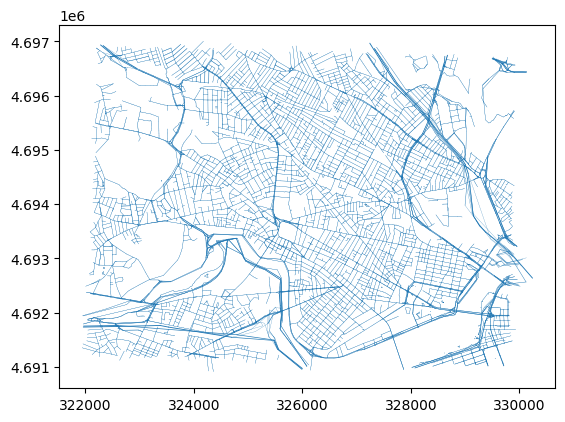

In [26]:
network_gdf.plot()

### Identify segments larger than the window size (300m x 300m)

In [27]:
is_long=network_gdf['distance']>300000
long_segments_gdf=network_gdf.loc[is_long]
network_gdf=network_gdf.loc[~is_long]

# Create Rasters

In [28]:
def create_grid(cell_size, total_depth, total_width, start_x, start_y):
    bottom_left_grid=[]
    for i in range(int(total_depth/ cell_size)):
        for j in range(int(total_width/ cell_size)):
            bottom_left_grid.append([start_x+j*cell_size, 
                                     start_y+i*cell_size])
    cells=[]
    for i in range(len(bottom_left_grid)):
        coords=[bottom_left_grid[i], 
                [bottom_left_grid[i][0]+cell_size, bottom_left_grid[i][1]], 
                [bottom_left_grid[i][0]+cell_size, bottom_left_grid[i][1]+cell_size], 
                [bottom_left_grid[i][0], bottom_left_grid[i][1]+cell_size],
                bottom_left_grid[i]]
        cell_poly=Polygon(coords)
        cells.append(cell_poly)
    cells_gdf=gpd.GeoDataFrame(geometry=cells)
    cells_gdf['cell_id']=list(range(len(cells_gdf)))
    return cells_gdf

In [29]:
def create_point_grid(cell_size, total_depth, total_width, centre_start_x, centre_start_y, crs):
    """
    From top left, row by row
    """
    centroid_grid=[]
    for i in range(int(total_depth/ cell_size)):
        for j in range(int(total_width/ cell_size)):
            centroid_grid.append(Point([(centre_start_x+j*cell_size)+cell_size/2, 
                                     (centre_start_y-i*cell_size)-cell_size/2]))
    centroid_gdf=gpd.GeoDataFrame(geometry=centroid_grid, crs=crs)
    centroid_gdf['cell_id']=list(range(len(centroid_gdf)))
    return centroid_gdf

In [30]:
def get_feature_raster(centre_start_x, centre_start_y, spaces, network_gdf, long_segments_gdf,
                      cell_size, window_side_length):
    grid_size=int(window_side_length/cell_size)
    grid=create_point_grid(cell_size=cell_size, total_depth=window_side_length,
                       total_width=window_side_length,
                       centre_start_x=centre_start_x,
                       centre_start_y=centre_start_y, 
                       crs=spaces.crs)
    subset=spaces.cx[start_x: start_x+window_side_length,
                   start_y-window_side_length: start_y]
    spaces_over_grid =gpd.overlay(grid, subset, keep_geom_type=False, how='identity')
    
    net_subset=network_gdf.cx[start_x: start_x+window_side_length,
                       start_y-window_side_length: start_y]
    net_subset=pd.concat([net_subset, long_segments_gdf])
    spaces_over_net=gpd.overlay(spaces_over_grid, net_subset, keep_geom_type=False, how='identity')
    spaces_over_net=spaces_over_net.sort_values(['cell_id', 'lanes']).drop_duplicates(subset=['cell_id'])
    spaces_over_net['simple_cat']=spaces_over_net['simple_cat'].fillna('None')
    spaces_over_net['floors']=spaces_over_net['floors'].fillna(1)
    
    is_road=~(spaces_over_net['highway'].isnull())
    spaces_over_net.loc[is_road, 'simple_cat']='Road'
    spaces_over_net.loc[is_road, 'floors']=1
    spaces_over_net['color']=spaces_over_net['simple_cat'].apply(get_color)
    
    summary=spaces_over_net.groupby('simple_cat')['floors'].sum()
    
    for ch in ['r', 'g', 'b', 'a']:
        spaces_over_net[ch]=0
    spaces_over_net['r']=[c[0] for c in spaces_over_net['color']]
    spaces_over_net['g']=[c[1] for c in spaces_over_net['color']]
    spaces_over_net['b']=[c[2] for c in spaces_over_net['color']]
    spaces_over_net['a']=255*(spaces_over_net['floors']/max_floors)
    
    raster=np.array(spaces_over_net[['r', 'g', 'b', 'a']]).reshape([grid_size, grid_size, 4])
    return raster, summary

In [31]:
WINDOW=256
CELL_SIZE=2
print(WINDOW/CELL_SIZE)
IMAGE_DIR='images_256_128'

128.0


### Set the starting coordinates of the samples 

In [32]:
space_centroids=spaces.geometry.centroid
spaces['x']=[c.x for c in space_centroids]
spaces['y']=[c.y for c in space_centroids]

spaces['grid_start_x']=(spaces['x']-WINDOW/2)
spaces['grid_start_y']=(spaces['y']+WINDOW/2)
xy=np.array(spaces[['grid_start_x', 'grid_start_y']])

In [33]:
spaces=spaces.reset_index(drop=True)

In [ ]:
all_metrics=[]

for i in range(xy.shape[0]):
    if i%100==0:
        print('{} of {}'.format(i, len(xy)))
    start_x, start_y=xy[i, :]
    raster, summary=get_feature_raster(centre_start_x=start_x+CELL_SIZE/2, 
                                       centre_start_y=start_y-CELL_SIZE/2, 
                                       spaces=spaces, network_gdf=network_gdf, 
                                       long_segments_gdf=long_segments_gdf,
                                       cell_size=CELL_SIZE, window_side_length=WINDOW)
    img = Image.fromarray(np.uint8(raster), 'RGBA')
    img.save('{}/im_{}.png'.format(IMAGE_DIR, i))
    
    all_metrics.append(dict(summary))
    if i%100==0:
        with open('{}/metrics.json'.format(IMAGE_DIR), 'w') as f:
            json.dump(all_metrics, f)

0 of 17402
100 of 17402


In [ ]:
i

In [ ]:
with open('{}/metrics.json'.format(IMAGE_DIR), 'w') as f:
    json.dump(all_metrics, f)
print(len(all_metrics))

In [ ]:
raster_no_alpha=raster[:, :, :3]
height_raster=raster[:, :, 3]

fig, axes=plt.subplots(1, 2)

im1 = axes[0].imshow(raster_no_alpha/255)

im2 = axes[1].imshow(height_raster)